# Chapter 11. Training Deep Neural Networks

Below are a list of the common challenges faced when training a Deep Neural Network (DNN):

* *Vanishing gradients* and *exploding gradients* are when a gradient grow smaller and smaller, or larger and larger, when flowing back through the DNN. This makes training the lower levels difficult.
* More training data is required.
* Each iteration takes longer.
* With more parameters to train, overfitting becomes an even bigger problem.

The following sections will address (more or less) in order.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from IPython.core.interactiveshell import InteractiveShell

np.random.seed(0)

plt.style.use('seaborn-whitegrid')

In [2]:
%matplotlib inline

In [3]:
%load_ext ipycache

/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/IPython/config.py:13: ShimWarning: The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.
  "You should import from traitlets.config instead.", ShimWarning)
/opt/anaconda3/envs/daysOfCode-env/lib/python3.7/site-packages/ipycache.py:17: UserWarning: IPython.utils.traitlets has moved to a top-level traitlets package.
  from IPython.utils.traitlets import Unicode


## The vanishing/exploding gradients problems

A *vanishing gradient* is when the gradients get smaller and smaller as the training algorithm progresses to to the lower layers.
This results in the parameter weights in the lower layers unchanged from initialization.
An *exploding gradient* is the opposite and the parameter weights get larger and larger and the training diverges.
This is primary a problem in Recurrent NN, discussed in a later chapter.

In 2010, Glorot and Bengio proposed that this was caused by the random initialization procedure commonly used: samples from a normal distribution.
This caused the variance in the initial weight parameters to be greater than that of the input, thus obfuscating the important information.
They proposed an initialization strategy, *Glorot initialization*, such that the variance of the input to the layer is the same as the variance of the output of the layer.
There are other variants of the process that have proven to work better with various activation functions; Table 11-1 on pg. 334 shows the best initialization methods for the activation function of the neuron, and it is replecated below.

| Initialization method | Activation function           | $\sigma^2$           |
|:----------------------|:------------------------------|:---------------------|
| Glorot                | None, tanh, logistic, softmax | $1/fan_{\text{avg}}$ |
| He                    | ReLU and variants             | $2/fan_{\text{in}}$  |
| LeCun                 | SELU                          | $1/fan_{\text{in}}$  |

By default, Keras uses the Glorot initialization with a uniform distribution.
The initialization can also be changed to He initialization by setting the `kernel_initializer` argument to `he_uniform` or `he_normal`:

In [4]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

Also, the details of an initializer can be specified by using the `VarianceScaling` class.
The following example uses He initialization with a uniform distribution based on $fan_{\text{avg}}$.

In [5]:
he_avg_init = keras.initializers.VarianceScaling(scale=2.0, 
                                                 mode='fan_avg', 
                                                 distribution='uniform')
keras.layers.Dense(10, activation='sigmoid', kernel_initializer=he_avg_init)

### Nonsaturating activation functions

In the same paper, Glorot and Bengio indicated that the activation function of choice, the logistic, was also a problem.
Thus they proposed the *Rectified Linear Unit* (ReLU) for faster and nonsaturating training.
The ReLU wasn't perfect, mainly because, during training, some neurons can "die," meaning that they only output 0 (called a *dying ReLU*).
Therefore, variants emerged such as the *leaky ReLU* (LeakyReLU), *Randomized leaky ReLU* (RRELU), and the *parametric leaky ReLU* (PReLU).
The LeakyReLU includes another hyperparameter $\alpha$ that lets the ReLU have a slightly positive slope when inputs are negative: $\text{LeakyReLU}_\alpha (z) = \max(\alpha z, z)$ (shown below).
The RReLU is the same as the LeakyReLU, but $\alpha$ is picked randomly within a range during training and fixed to an average during testing.
The PReLU is where $\alpha$ is turning into an additional parameter to be learned (this can lead to further overfitting, though).

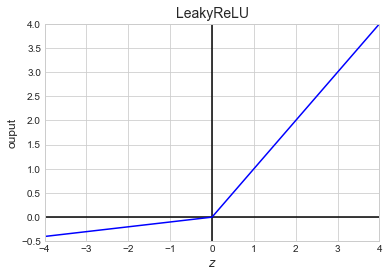

In [6]:
def leakyReLU(x, alpha=0.01):
    return [i if i>=0 else i*alpha for i in x]

x = np.arange(-4, 5, 1, dtype=np.float64)

plt.plot(x, np.repeat(0, len(x)), 'k-')
plt.plot([0, 0], [-1, 5], 'k-')
plt.plot(x, leakyReLU(x, 0.1), 'b-')
plt.axis([-4, 4, -0.5, 4])
plt.xlabel('$z$', fontsize=12)
plt.ylabel('ouput', fontsize=12)
plt.title('LeakyReLU', fontsize=14)
plt.show()

Another useful activation function is the *exponential linear unit* (ELU) that is a linear funciton when the input is greater than 0 and an exponential when it is less than 0:

$$
\begin{aligned}
\text{ELU}_\alpha (z) = \begin{cases}
\alpha (\exp(z) - 1) &\text{ if } z < 0 \\
z                    &\text{ if } z \ge 0
\end{cases}
\end{aligned}
$$

In addition, there is the *scaled ELU* (SELU) that will produce a network that *self-normalizes*, each layer will naturally preserve the output with a mean of 0 and standard deviation of 1.
This is only guaranteed under the following circumstances:

* The ANN must be a stack of dense, sequentially connected layers.
* The input must be standardized to mean 0 and standard deviation 1.
* The layer weights must be initialized with LeCun normal initialization (`kernel_initializer='lecun_normal'`).

Obviously the first bullet is quite a limitation, though researchers have indicated that the SELU can be used in some cases where the layers aren't dense, such as a convolutional neuron network (Chapter 14).

To use a LeakyReLU in keras, it gets added as a separate layer after the layer you want it to apply to.

In [7]:
# An example ANN with a LeakyReLU layer.
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=5),
    keras.layers.Dense(10, kernel_initializer='he_normal'),
    keras.layers.LeakyReLU(alpha=0.2),
    keras.layers.Dense(1)
])

Below is an example of using the SELU activation function.

In [8]:
keras.layers.Dense(10, activation='selu', kernel_initializer='lecun_normal')

The author proposes the following order of preference for the activation functions covered above:

> SELU > ELU > LeakyReLU (and its variants) > ReLU > tanh > logistic

though he does provide practical reasons why you would choose one over another.

### Batch normalization

*Batch Normalization* (BN) is another safeguard against the vanishing and exploding gradients problems.
BN zero-centers and normalizes each input, then scales and shifts the result using two new parameter vectors per layer: one for scaling and the other for shifting.
The goal is to learn the optimal scale and mean for the inputs to each layer.
To get final values for the model, a running average is maintained of each layer's mean and standard deviation.

In practice, BN has shown great success in reducing the problem of vanishing and exploding gradients, even when using saturating activation functions.

Though there are performance issues during training because there are now additional layers and parameters to learn, training is often slower because fewer rounds of training are required.
Further, once the model is trained, the new layers from BN can be incorporated into the previous layer.
This is does by updating the previous layer's weights and biases to output the correct scale and offset learned by the BN layer.

Here is an example of using BN with Keras for an image classifier.
It is added just before or after each hidden layer's activation function and as the first layer in the model (after flattening the image, though).

In [9]:
model_1 = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation='softmax'),
])

model_1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_5 (Dense)              (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_6 (Dense)              (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

There is some disagreement over whether the BN layer should be added before or after the activation functions.
Below is an example of creating a model with the BN layer *before* the activation function.
The activation functions must be separated from the hidden layers and added separately after the BN layers.

In [10]:
model_2 = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(100, kernel_initializer='he_normal', use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation('elu'),
    keras.layers.Dense(10, activation='softmax')
])

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 784)               3136      
_________________________________________________________________
dense_8 (Dense)              (None, 300)               235200    
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
activation (Activation)      (None, 300)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               30000     
_________________________________________________________________
batch_normalization_5 (Batch (None, 100)              

The "non-trainable" parameters the running averages for the means and standard deviations of each BN layer because they are not trained by the back-propagation.
Below are the parameters for the first BN layer.

In [11]:
[(var.name, var.trainable) for var in model_1.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

Generally, the default hyperparamters for BN are good enough.
The two that may be worth changing are `momentum` and `axis`.
The momentum determines how much the newly computed batch means and standard deviations ($\textbf{v}$) should contribute to the running parameter averages weights ($\hat{\textbf{v}}$):

$\hat{\textbf{v}} \leftarrow \hat{\textbf{v}} \times \text{momentum} + \textbf{v} \times (1 - \text{momentum})$

The axis argument determines on which axis or axes the normalization occurs.
The default is the last axis, which for flat input data is good, but is not likely applicable for input data matrices with greater than two dimensions.

### Gradient clipping

The maximum and minimum gradient can be set to prevent exploding gradients.
Two parameters in `keras.optimizers.SGD()` can be set to do this.
The first, `clipvalue`, sets the minimum and maximum values and then just reduces any gradient over/under the values to the maximum/minimum value.
Thus, if `clipvalue=1.0` then the maximum and minimum gradients are [-1.0, 1.0] and a gradient of [0.7, 1.1] is clipped to [0.7, 1.0].
The main problem with setting the `clipvalue` is that is changes the *direction* of the gradient.
This is resolved by setting `clipnorm` which scales the gradient such that all the individual values fit within the limit, thus not changing the direction, just the magnitude of the gradient.
For example if `clipnorm=1.0` then the vector [0.9, 100.0] becomes [0.00899964, 0.9999595] instead of [0.9, 1.0] with `clipvalue=1.0`.

### Using pretrained layers

The author advises that, "It is generally not a good idea to train a very large DNN from scratch," (HOML, pp. 345).
Instead, a pretrained DNN can be downloaded and most of the layers reused.
This is called *transfer learning*.
The upsides are that is will speed up training considerably and requires less training data.

In general, it is best to begin by retraining the upper layers while "freezing" the lower layers because they are more likely to have learned generalizable patterns.
The more similar the new task is to the one for the original model, the more layers can be reused.
Here is a process that will be generally advisable for *transfer learning*:

1. Freeze all of the reused layers, train, and validate. This would only be training the output layer that is custom for the problem at hand.
2. Unfreeze the top one or two layers, train, and validate. This lets back propagation train the last one or two layers in the network, leaving most of them untouched. 
3. If you have a lot of training data, you can unfreeze more layers. It is advisable to reduce the learning rate, though.
4. Finally, try experimenting with adding additional layers or replacing the last few layers of the original model.

### Transfer learning with Keras

Below is an example of training `model_B` on top of `model_A`.
First, `model_A` is created, trained, and saved to file.

In [12]:
from sklearn.model_selection import train_test_split
import pathlib

# Pepare data.
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", 
               "Shirt", "Sneaker", "Bag", "Ankle boot"]

# Split into training and validation data.
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full,
                                                      y_train_full,
                                                      test_size=0.2,
                                                      random_state=0)

# Construct model A
model_A = keras.models.Sequential([
    keras.layers.Flatten(input_shape = X_train.shape[1:]),
    keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(200, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(100, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(50, activation='elu', kernel_initializer='he_normal'),
    keras.layers.Dense(10, activation='softmax'),
])

# Compile model A
model_A.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(learning_rate=1e-4),
    metrics=['accuracy']
)

# Train model A (only a few epochs)
history_A = model_A.fit(
    X_train, y_train,
    epochs=3,
    validation_split=0.2,
    verbose=1
)

# Save model to file.
model_A_path = pathlib.Path("assets/ch06/ch11/model_A.h5")
model_A.save(model_A_path.as_posix())

Train on 38400 samples, validate on 9600 samples
Epoch 1/3
38400/38400 [==============================] - 11s 284us/sample - loss: 3.6792 - accuracy: 0.6599 - val_loss: 1.4006 - val_accuracy: 0.7105
Epoch 2/3
38400/38400 [==============================] - 10s 254us/sample - loss: 1.1440 - accuracy: 0.7265 - val_loss: 1.0446 - val_accuracy: 0.7365
Epoch 3/3
38400/38400 [==============================] - 10s 254us/sample - loss: 0.8715 - accuracy: 0.7540 - val_loss: 0.9083 - val_accuracy: 0.7368


Now the transfer learning can begin.
First, model A is read in from file.
Then `model_B_on_A` consists of all but the last layer of model A and a new layer is added for model B.
The goal of model B is to classify the fashion image as shirt (positive) or sandal (negative). 

In [13]:
# Get training data for just Shirts and Sandals.
train_idx = [(y==0 or y==5) for y in y_train]
X_train_B = X_train[train_idx, :, :]
y_train_B = y_train[train_idx]
y_train_B = (np.array(y_train_B) == 5)

model_A = keras.models.load_model(model_A_path.as_posix())
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

However, the training of `model_B_on_A` will change the layers in `model_A`.
If this is not wanted, then model A must be cloned and the weights copied.
An example of this is shown below.

In [14]:
# Clone the model.
model_A_clone = keras.models.clone_model(model_A)

# Copy the weights (not does by `clone_model()` method.)
model_A_clone.set_weights(model_A.get_weights())

Now we can train `model_B_on_A`.
However, we want to freeze the layers from model A for the first few epochs.
It is important to remember to recompile the model after layers are (un)frozen.

In [15]:
# Freeze original layers for first training rounds.
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

# Recompile the model with only the top layer to be trained.
model_B_on_A.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=['accuracy'])

# Train the top layer.
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_split=0.2)

Train on 7676 samples, validate on 1920 samples
Epoch 1/4
7676/7676 [==============================] - 3s 350us/sample - loss: 0.4199 - accuracy: 0.9491 - val_loss: 0.0441 - val_accuracy: 0.9875
Epoch 2/4
7676/7676 [==============================] - 2s 199us/sample - loss: 0.0622 - accuracy: 0.9875 - val_loss: 0.0360 - val_accuracy: 0.9901
Epoch 3/4
7676/7676 [==============================] - 2s 199us/sample - loss: 0.0554 - accuracy: 0.9889 - val_loss: 0.0336 - val_accuracy: 0.9901
Epoch 4/4
7676/7676 [==============================] - 2s 213us/sample - loss: 0.0520 - accuracy: 0.9902 - val_loss: 0.0308 - val_accuracy: 0.9922


Then the lower layers can be unfrozen, the model recompiled, and additional rounds of training run.
Note that the learning rate is reduced by an order of magnitude.

In [16]:
for layer in model_B_on_A.layers:
    layer.trainable = True

model_B_on_A.compile(loss='binary_crossentropy',
                     optimizer=keras.optimizers.SGD(learning_rate=1e-4),
                     metrics=['accuracy'])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_split=0.2)

Train on 7676 samples, validate on 1920 samples
Epoch 1/4
7676/7676 [==============================] - 3s 439us/sample - loss: 0.0452 - accuracy: 0.9914 - val_loss: 0.0262 - val_accuracy: 0.9927
Epoch 2/4
7676/7676 [==============================] - 2s 292us/sample - loss: 0.0298 - accuracy: 0.9937 - val_loss: 0.0251 - val_accuracy: 0.9927
Epoch 3/4
7676/7676 [==============================] - 2s 270us/sample - loss: 0.0219 - accuracy: 0.9952 - val_loss: 0.0243 - val_accuracy: 0.9927
Epoch 4/4
7676/7676 [==============================] - 2s 271us/sample - loss: 0.0168 - accuracy: 0.9965 - val_loss: 0.0238 - val_accuracy: 0.9932


In [17]:
test_idx = [(y==0 or y==5) for y in y_test]
X_test_B = X_test[test_idx, :, :]
y_test_B = (np.array(y_test[test_idx]) == 5)

test_loss, test_accuracy = model_B_on_A.evaluate(X_test_B, y_test_B, verbose=0)

print(f'    test loss: {np.round(test_loss, 3)}')
print(f'test accuracy: {np.round(test_accuracy * 100, 3)}%')

    test loss: 0.029
test accuracy: 99.25%


**In general, transfer learning is only useful for *very* deep networks, specifically convolutional neural networks (CNN, Chapter 14).**
This is likely because shallow networks do not learn generalizable patterns in the lower layers while CNNs do.

### Unsupervised pretraining

If there is little labeled data and no previously trained model you can use with transfer learning, unlabeled data can be used for *unsupervised pretraining*.
This is where an unsupervised model, often an autoencoder or generative adversarial network (GAN; Chapter 17) are trained on the unlabeled data and then the layers of the model are used as the lower layers for a DNN.

### Pretraining on auxiliary data

Another alternative for when there is little labeled data is to train a DNN on a related task where there is plenty of data, and then use the trained lower layers for another DNN for your desired task.

## Fast optimizers

Another way to reduce the amount of time required for training is to use a better optimizer than SGD.
Below are some of the most common options.

### Momentum optimization

If a ball is rolling down a hill with a constant slope, it will speed up over time even though the gradient has not changed.
This is the intuition behind *momentum optimization*.
At each iteration, the local gradient is subtracted from the *momentum vector* $\textbf{m}$ and updates the weights by adding the momentum vector.
This way, the gradient acts  more as acceleration than as the speed.
Below are the equations for calculating the momentum vector and then the parameter weights where $\beta$ is the momentum, a parameter to limit the momentum vector, and $\eta$ is  the learning rate, and $J(\theta)$ is the cost function for the current value of the networks parameters $\theta$.

$
\textbf{m} \leftarrow \beta \textbf{m} -  \eta \nabla_{\theta} J(\theta) \\
\theta \leftarrow \theta + \textbf{m}
$

To use the momentum optimization in keras, set the `momentum` parameter in the the `SGD` optimizer.

In [18]:
keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

### Nesterov accelerated gradient

The *Nesterov accelerated gradient* (NAG) is a slight enhancement of momentum optimization.
It measures the gradient not at the current location in the parameter space, but slightly ahead at $\theta + \beta \textbf{m}$:

$
\textbf{m} \leftarrow \beta \textbf{m} -  \eta \nabla_{\theta} J(\theta + \beta \textbf{m}) \\
\theta \leftarrow \theta + \textbf{m}
$

It generally helps by slightly adjusting the current direction of the momentum vector towards the minima.
It is trivial to implement in keras, and because it is usually faster than momentum optimization, it is recommended to apply:

In [19]:
keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9, nesterov=True)

### AdaGrad

AdaGrad uses an *adaptive learning rate* strategy to scale (decay) the learning rate faster for steeper dimensions.
It is very simillar to SGD, but divides the loss for each parameter by the square of the gradient (with an additional smoothing value $\epsilon$):

$
\textbf{s} \leftarrow \textbf{s} + \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)  \\
\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{\textbf{s} + \epsilon}
$

**AdaGrad scales the learning rate too quickly for training DNNs - do NOT use it.**

In [20]:
keras.optimizers.Adagrad(learning_rate=1e-3, epsilon=1e-7)

(The default behaviour of many optimizers is to use `keras.backend.epsilon()` of `epsilon`.
It is effectively a global variable that can be set using `keras.backend.set_epsilon()`.
If the default value for `epsilon` is `None`, then it is likely using this value.)

### RMSProp

This is simillar to AdaGrad, but fixes the issue of decaying the gradient too quickly by accumulating only the more recent gradients, where $\beta$ is  the decay rate (the memory):

$
\textbf{s} \leftarrow \beta \textbf{s} + (1 - \beta) \nabla_\theta J(\theta) \otimes \nabla_\theta J(\theta)  \\
\theta \leftarrow \theta - \eta \nabla_\theta J(\theta) \oslash \sqrt{\textbf{s} + \epsilon}
$

$\beta$ is another hyperparameter to tune, though the default value of 0.9 is usually sufficient.

In [21]:
keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9)

### Adam and  Nadam  Optimization

The *adaptive moment estimation* (Adam) optimizer uses a combination of momentum optimization and RMSProp (the simillarities are quite obvious in the algorithm on pp. 356 of *HOML*.
There are three hyperparameters to set, though the defaults (used below) are usually sufficient.

In [22]:
keras.optimizers.Adam(learning_rate=1e-3, 
                      beta_1=0.9, 
                      beta_2=0.999, 
                      epsilon=1e-7)

There are two optimizers derived from Adam that the author touched upon.
*AdaMax* is a reworking of the Adam algorithm to make it a bit more stable.
Still, Adam tends to perform better.
*Nadam* is Adam with the Nesterov trick.
It usually converges faster and is generally recommended to try it out.

In [23]:
# AdaMax optimizer (default arguments)
keras.optimizers.Adamax(learning_rate=0.001,
                        beta_1=0.9,
                        beta_2=0.999,
                        epsilon=1e-07)

# Nadam optimizer (default arguments)
keras.optimizers.Nadam(learning_rate=0.001,
                       beta_1=0.9,
                       beta_2=0.999,
                       epsilon=1e-07)

### Learning Rate Scheduling

A dynamic learning rate, one that changes during the training, is usually better than a static learning rate.
Here are some of the more popular *learning schedules*.

* **Power scheduling**: The learning rate is a function of the iteration number $t$: $\eta(t) = \eta_0 / (1 + t/s)^c$ where $s$, $c$, and $\eta_0$ are all hyperparameters to tune. This equation drops the learning rate quickly at first, but then the changes are smaller.
* **Exponential scheduling**: Set the learning rate to $\eta(t) = \eta_0 0.1^{t/s}$. This equation reduces the learning rate by a factor of 10 every $s$ steps.
* **Piecewise constant scheduling**: Assign specific learning rates to each range of training iterations.
* **Performance scheduling**: Measure the validation error every $N$ steps and reduce the learning rate by a factor of  $\gamma$ when the error stops dropping.
* **Icycle scheduling**: This is a more complicated schedule that raises the learning rate linearly during the first half of training, and then reduces it linearly in the second half. It does the opposite for the momentum.

Implementing these in keras is pretty easy.
First, power  scheduling can be accomplished using the `decay` argument in the `SGD` optimizer class. (The $c$ hyperparameter is automatically set to 1.)

In [24]:
keras.optimizers.SGD(learning_rate=1e-2, momentum=0.9, decay=1e-4)

Implementing exponential scheduling is fairly straightforward, too.
First, a function that takes the iteration number and returns the learning rate must be defined.
Then, a `LearningRateScheduler` callback is made an provided the function.
The callback is then passed to the `fit()` method.

Here, the function `exponential_decay()` takes the initial learning rate and $s$ hyperparameter value and returns another function that implements the exponential decay scheduler for a given epoch.

In [25]:
def exponential_decay(lr0, s):
    """Return a LR scheduling function with the desired hyperparameters."""
    return lambda epoch: lr0 * 0.1**(epoch / s)

# Learning rate scheduling function with initial learning rate and s.
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

# A learning rate scheduler callback to implement the exponential scheduler.
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

# Pass `lr_scheduler` to the `fit()` method for training.

If needed, the schedule function can take the current learning rate as a second argument.

The *performance scheduler* can be implemented using the `ReduceLROnPlateau` callback.
It multiplies the current learning rate by a desired factor after a certain number of epochs without improvement.

In [26]:
keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

TensorFlow's implementation of Keras offers the ability to define a learning rate schedule using an object in `keras.optimizers.schedules` and then pass it to an optimizer.
**This approach updates the learing rate at each step rather than at each epoch.**
Below is an example of exponential decay where the number of steps is the total number of training steps in 20 epochs and a batch size of 32.

In [27]:
# Training hyperparameters.
n_epochs = 20
batch_size = 32

# Learning rate scheduler.
s = n_epochs * len(X_train) // batch_size
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)

# SGD using the exponential LR scheduler.
optimizer =  keras.optimizers.SGD(learning_rate)

## Avoiding overfitting through regularization

We have already covered two powerful techniques that act like regularization: early stopping and Batch Normalization.

### $\ell_1$ and $\ell_2$ regularization

Both $\ell_1$ and $\ell_2$ can easily be used to constrain a layer's weights. 
$\ell_1$ forces more weights to 0 and thus creates more sparse networks.
Here is an example of a dense layer that applies $\ell_2$ regularization to its connection weights with a regularization factor of 0.01 (how strong of a penalty to use):

In [28]:
keras.layers.Dense(100,
                   activation='elu',
                   kernel_initializer='he_normal',
                   kernel_regularizer=keras.regularizers.l2(0.01))

However, defining this for each layer of a network would become repetitive.
One way around this would be to implement a for-loop.
Alternatively, Python's `functools.partial()`, a function that can create a thin wrapper for any callable, can be used to create a proto-layer with desireable defaults.

In [29]:
from functools import partial

# A wrapper around a Dense layer with L2-regularization.
RegularizedDense = partial(
    keras.layers.Dense,
    activation='elu',
    kernel_initializer='he_normal',
    kernel_regularizer=keras.regularizers.l2(0.01)
)

# A sequential model.
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, 
                     activation='softmax', 
                     kernel_initializer='glorot_uniform'),
])

### Dropout
